In [148]:
import os
import pandas as pd

# Đường dẫn thư mục dữ liệu gốc và thư mục lưu kết quả
input_folder = r"data/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv"
output_folder = r"processed_data"

# Tạo thư mục processed_data nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)
processed_person_count = 0
# Số lượng người: 01 đến 53
for i in range(1, 54):
    full_processed = True

    # Định dạng số với 2 chữ số
    subj_id = f"{i:02d}"
    # Tạo thư mục con cho mỗi người
    subj_folder = os.path.join(output_folder, f"bidmc_{subj_id}")
    os.makedirs(subj_folder, exist_ok=True)
    
    # Đường dẫn file
    signals_file = os.path.join(input_folder, f"bidmc_{subj_id}_Signals.csv")
    numerics_file = os.path.join(input_folder, f"bidmc_{subj_id}_Numerics.csv")
    breaths_file = os.path.join(input_folder, f"bidmc_{subj_id}_Breaths.csv")
    
    # 1. Đọc và trích xuất từ Signals: chỉ lấy cột "Time [s]" và "PLETH"
    if os.path.exists(signals_file):
        df_signals = pd.read_csv(signals_file)
        df_signals.columns = df_signals.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_signals.columns and 'PLETH' in df_signals.columns:
            df_signals = df_signals[['Time [s]', 'PLETH']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Lưu file đã xử lý
        df_signals.to_csv(os.path.join(subj_folder, "Signals_processed.csv"), index=False)
    
    # 2. Đọc và trích xuất từ Numerics: lấy cột "Time [s]", "HR" và "RESP"
    if os.path.exists(numerics_file):
        df_numerics = pd.read_csv(numerics_file)
        df_numerics.columns = df_numerics.columns.str.strip()

        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_numerics.columns and 'HR' in df_numerics.columns and 'RESP' in df_numerics.columns:
            df_numerics = df_numerics[['Time [s]', 'HR', 'RESP']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False

        # Lưu file đã xử lý
        df_numerics.to_csv(os.path.join(subj_folder, "Numerics_processed.csv"), index=False)
    
    # 3. Đọc và trích xuất từ Breath: chọn cột annotator (ví dụ: đặt lại tên thành "ann1", "ann2")
    if os.path.exists(breaths_file):
        df_breaths = pd.read_csv(breaths_file)
        df_breaths.columns = df_breaths.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'breaths ann1 [signal sample no]' in df_breaths.columns and 'breaths ann2 [signal sample no]' in df_breaths.columns:
            # Đổi tên cột cho dễ đọc
            rename_dict = {}
            for col in df_breaths.columns:
                if "ann1" in col.lower():
                    rename_dict[col] = "ann1"
                elif "ann2" in col.lower():
                    rename_dict[col] = "ann2"
            if rename_dict:
                df_breaths.rename(columns=rename_dict, inplace=True)

            df_breaths = df_breaths[['ann1', 'ann2']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Giả sử tên cột ban đầu là "breaths ann1 [signal sample no]" và "breaths ann2 [signal sample no]"
        
        # Lưu file đã xử lý
        df_breaths.to_csv(os.path.join(subj_folder, "Breaths_processed.csv"), index=False)
    if not full_processed:
        print(f"Không đúng tên cột hoặc không đủ dữ liệu dữ liệu cho người {subj_id}. Bỏ qua.")
        continue
    processed_person_count += 1

# Thông báo đã xử lý xong một người
print(f"Đã xử lý dữ liệu cho {processed_person_count} người.")

# Sau khi xử lý xong, ta sẽ làm sạch dữ liệu trong các file đã lưu trong thư mục processed_data
print("Bắt đầu làm sạch dữ liệu...")

# Sau khi lưu dữ liệu, ta load lại dữ liệu từ processed_data để xử lý các giá trị null hoặc không hợp lệ
# Ví dụ: điền giá trị bị thiếu (fillna) với phương pháp forward fill, và sau đó loại bỏ nếu vẫn còn null.
def clean_dataframe(df, method='ffill'):
    # Áp dụng forward fill
    # df_clean = df.fillna(method=method)
    if method == 'ffill':
        df_clean = df.ffill()
    elif method == 'bfill':
        df_clean = df.bfill()
    else:
        raise ValueError("Chỉ hỗ trợ 'ffill' hoặc 'bfill'")
    # Nếu vẫn còn null, loại bỏ các dòng chứa null
    df_clean = df_clean.dropna()
    return df_clean

# Duyệt qua từng thư mục con và làm sạch dữ liệu
for subj in os.listdir(output_folder):
    subj_path = os.path.join(output_folder, subj)
    if os.path.isdir(subj_path):
        # Danh sách file đã xử lý trong thư mục của người đó
        for file_name in os.listdir(subj_path):
            if file_name.endswith("_processed.csv"):
                file_path = os.path.join(subj_path, file_name)
                df = pd.read_csv(file_path)
                df_clean = clean_dataframe(df)
                # Lưu lại file sau khi làm sạch (có thể ghi đè file cũ)
                df_clean.to_csv(file_path, index=False)
                
print("Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.")


Đã xử lý dữ liệu cho 53 người.
Bắt đầu làm sạch dữ liệu...
Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.


## Xem dữ liệu

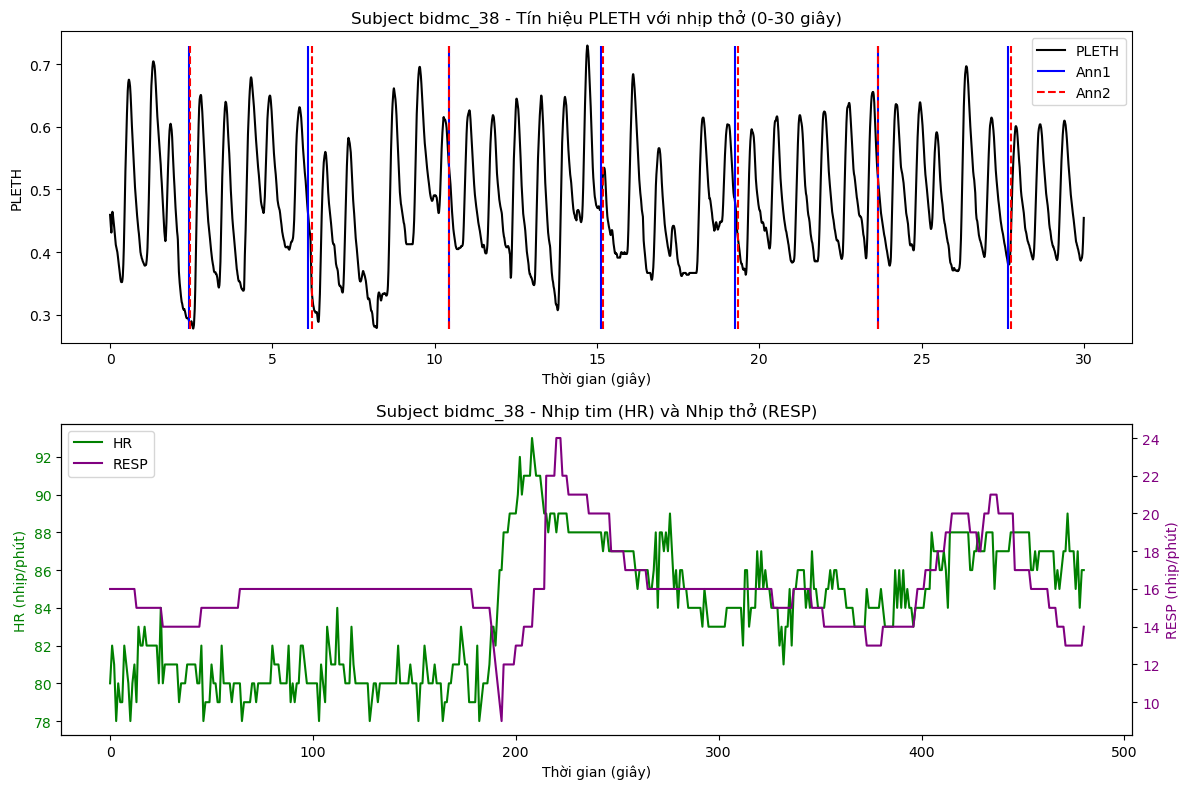

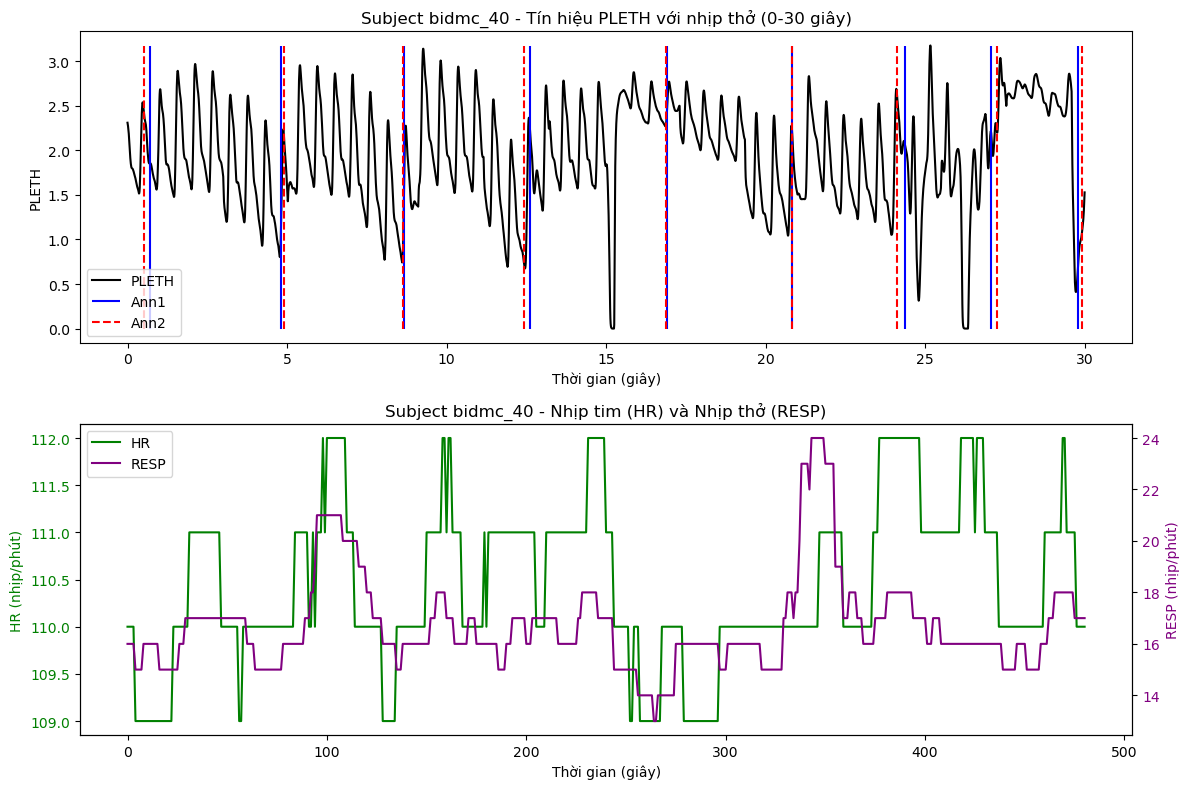

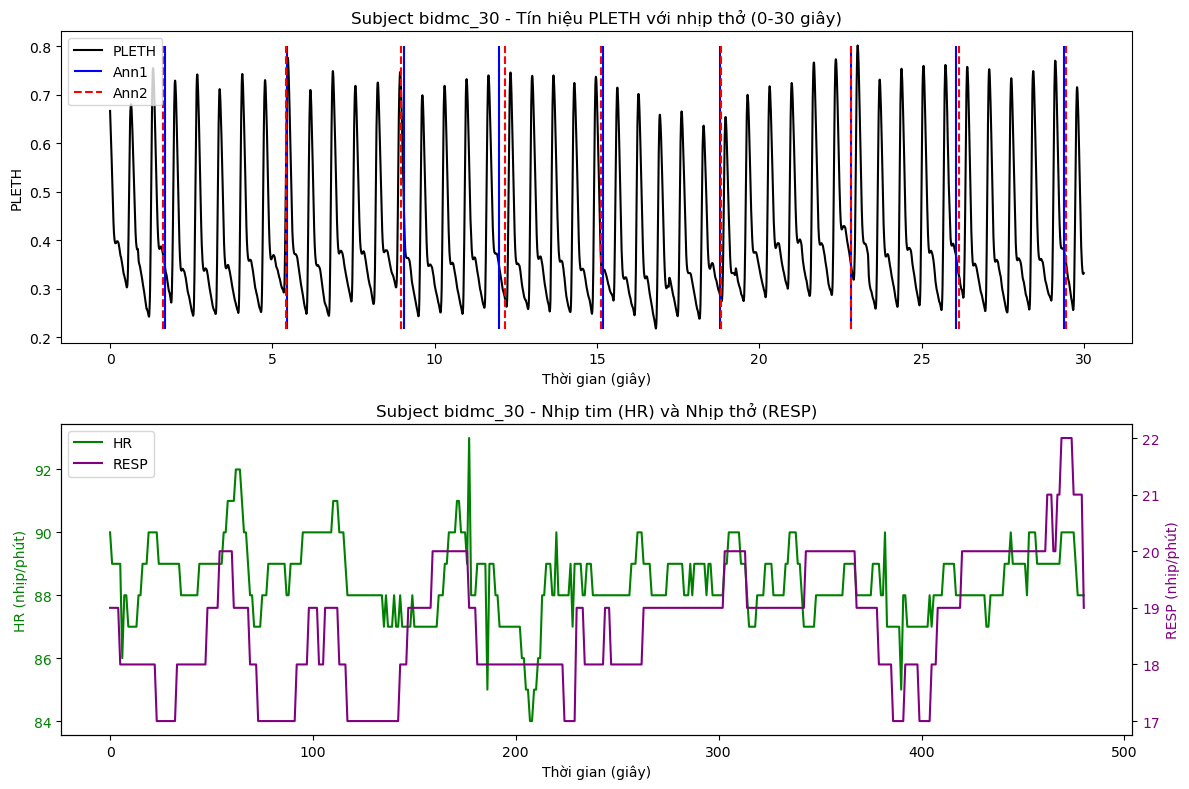

In [149]:
import matplotlib.pyplot as plt
import random

# Đường dẫn đến dữ liệu đã xử lý
base_dir = "processed_data"

# Tạo danh sách các subject IDs từ 01 đến 53
subject_ids = [f"{i:02d}" for i in range(1, 54)]

# Chọn ngẫu nhiên 3 subject
selected_subjects = random.sample(subject_ids, 3)

# Lặp qua từng subject được chọn
for subject in selected_subjects:
    # Tạo đường dẫn đến thư mục của subject
    subject_dir = os.path.join(base_dir, f"bidmc_{subject}")
    
    # Đọc các file CSV
    df_signals = pd.read_csv(os.path.join(subject_dir, 'Signals_processed.csv'))
    df_breaths = pd.read_csv(os.path.join(subject_dir, 'Breaths_processed.csv'))
    df_numerics = pd.read_csv(os.path.join(subject_dir, 'Numerics_processed.csv'))
    
    # Lấy đoạn tín hiệu PLETH từ 0 đến 30 giây
    pleth_segment = df_signals[df_signals['Time [s]'] <= 30]
    
    # Đảm bảo các sample number của breath annotations nằm trong phạm vi tín hiệu
    max_sample = len(df_signals) - 1
    valid_ann1 = df_breaths['ann1'][df_breaths['ann1'] <= max_sample]
    valid_ann2 = df_breaths['ann2'][df_breaths['ann2'] <= max_sample]
    
    # Chuyển sample number thành thời gian và lọc trong khoảng 0-30 giây
    breath_times_ann1 = df_signals['Time [s]'].iloc[valid_ann1]
    breath_times_ann1_segment = breath_times_ann1[breath_times_ann1 <= 30]
    
    breath_times_ann2 = df_signals['Time [s]'].iloc[valid_ann2]
    breath_times_ann2_segment = breath_times_ann2[breath_times_ann2 <= 30]
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Biểu đồ 1: PLETH signal với breath annotations
    ax1.plot(pleth_segment['Time [s]'], pleth_segment['PLETH'], label='PLETH', color='black')
    ax1.vlines(breath_times_ann1_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='blue', linestyles='solid', label='Ann1')
    ax1.vlines(breath_times_ann2_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='red', linestyles='dashed', label='Ann2')
    ax1.set_xlabel('Thời gian (giây)')
    ax1.set_ylabel('PLETH')
    ax1.legend()
    ax1.set_title(f'Subject bidmc_{subject} - Tín hiệu PLETH với nhịp thở (0-30 giây)')
    
    # Biểu đồ 2: HR và RESP
    ax2.plot(df_numerics['Time [s]'], df_numerics['HR'], color='green', label='HR')
    ax2.set_xlabel('Thời gian (giây)')
    ax2.set_ylabel('HR (nhịp/phút)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Tạo trục y thứ hai cho RESP
    ax2_r = ax2.twinx()
    ax2_r.plot(df_numerics['Time [s]'], df_numerics['RESP'], color='purple', label='RESP')
    ax2_r.set_ylabel('RESP (nhịp/phút)', color='purple')
    ax2_r.tick_params(axis='y', labelcolor='purple')
    
    # Thêm legend cho cả HR và RESP
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_r.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    ax2.set_title(f'Subject bidmc_{subject} - Nhịp tim (HR) và Nhịp thở (RESP)')
    
    # Điều chỉnh layout để tránh overlap
    plt.tight_layout()

# Hiển thị tất cả các biểu đồ
plt.show()

## Bắt đầu lọc nhiễu

In [150]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
ppg_data = pd.read_csv(r'processed_data\bidmc_01\Signals_processed.csv')  # PPG
numeric_data = pd.read_csv(r'processed_data\bidmc_01\Numerics_processed.csv')  # HR, RESP

# Giả sử cột: 'Time [s]', 'PLETH', 'HR', 'RESP'
segments = []
conditions = []
segment_seconds = 10  # 10 giây
segment_length = 125 * segment_seconds  # 125 samples cho mỗi 10 giây

for t in range(0, len(ppg_data) // segment_length):
    start_idx = t * segment_length
    end_idx = start_idx + segment_length
    if end_idx <= len(ppg_data):
        ppg_segment = ppg_data['PLETH'].iloc[start_idx:end_idx].values
        hr = numeric_data['HR'].iloc[t : t + segment_seconds].mean()
        resp = numeric_data['RESP'].iloc[t : t + segment_seconds].mean()
        segments.append(ppg_segment)
        conditions.append([hr, resp])

segments = np.array(segments)  # Shape: (num_segments, 125)
conditions = np.array(conditions)  # Shape: (num_segments, 2)

In [151]:
pd.DataFrame(segments)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,0.43597,0.43206,0.42815,0.42424,0.42131,0.41838,0.41740,0.41642,0.41544,0.41447,...,0.57185,0.57576,0.57771,0.57869,0.57869,0.57869,0.57674,0.57380,0.56989,0.56403
1,0.55718,0.54839,0.53763,0.52590,0.51417,0.50342,0.49462,0.48778,0.48289,0.47996,...,0.40860,0.40958,0.40762,0.40567,0.40469,0.40274,0.40176,0.40176,0.40274,0.40469
2,0.40860,0.41642,0.42717,0.44282,0.46237,0.48485,0.50440,0.52395,0.54545,0.56891,...,0.46530,0.46237,0.45846,0.45455,0.45064,0.44575,0.43988,0.43500,0.42913,0.42326
3,0.41740,0.41251,0.40860,0.40567,0.40371,0.40274,0.40078,0.39980,0.39883,0.39785,...,0.41153,0.41153,0.41153,0.41251,0.41349,0.41349,0.41349,0.41251,0.41153,0.40860
4,0.40665,0.40469,0.40274,0.40078,0.40078,0.40469,0.41153,0.42326,0.43891,0.45943,...,0.48289,0.50440,0.52493,0.54350,0.55816,0.56989,0.57869,0.58456,0.58749,0.58944
5,0.59140,0.59042,0.58944,0.58749,0.58358,0.57869,0.57185,0.56305,0.55132,0.53861,...,0.55718,0.56109,0.56696,0.57380,0.57771,0.57771,0.57674,0.57478,0.57185,0.56696
6,0.56012,0.55327,0.54545,0.53568,0.52493,0.51613,0.50831,0.50244,0.49756,0.49365,...,0.60606,0.60313,0.59824,0.59140,0.58358,0.57380,0.56207,0.54839,0.53470,0.52395
7,0.51417,0.50635,0.49951,0.49560,0.49365,0.49267,0.49267,0.49169,0.49169,0.49169,...,0.46432,0.46334,0.46237,0.46041,0.45748,0.45552,0.45259,0.45064,0.44770,0.44575
8,0.44477,0.44379,0.44086,0.43695,0.43206,0.42717,0.42229,0.41838,0.41544,0.41447,...,0.47214,0.46921,0.46530,0.45650,0.45259,0.44966,0.44673,0.44477,0.44282,0.44086
9,0.44086,0.44086,0.43988,0.43988,0.43988,0.43793,0.43500,0.43011,0.42620,0.42229,...,0.52004,0.52004,0.52004,0.52004,0.52004,0.52004,0.52004,0.51906,0.51808,0.51711


In [152]:
pd.DataFrame(conditions)

,0,1
0,93.6,25.7
1,93.6,25.8
2,93.6,25.9
3,93.6,26.0
4,93.8,26.0
5,93.9,26.0
6,94.1,26.0
7,94.1,26.0
8,94.1,25.8
9,94.1,25.6


In [153]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Chuẩn hóa PPG
segments_normalized = []
for seg in segments:
    scaler = StandardScaler()
    seg_normalized = scaler.fit_transform(seg.reshape(-1, 1)).flatten()
    segments_normalized.append(seg_normalized)
segments_normalized = np.array(segments_normalized)

# Chuẩn hóa HR và RESP
scaler_condition = MinMaxScaler()
conditions_normalized = scaler_condition.fit_transform(conditions)

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, C_train, C_test = train_test_split(
    segments_normalized, conditions_normalized, test_size=0.2, random_state=42
)

In [155]:
print(X_train.shape, C_train.shape)  # Kiểm tra kích thước dữ liệu huấn luyện
print(X_test.shape, C_test.shape)  # Kiểm tra kích thước dữ liệu kiểm tra

(38, 1250) (38, 2)
(10, 1250) (10, 2)


In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.flattened_size = 64 * 313  # Correct size based on conv output
        self.fc = nn.Linear(self.flattened_size + condition_dim, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, condition):
        x = x.unsqueeze(1)  # (batch_size, 1, 1250)
        h = F.relu(self.conv1(x))  # (batch_size, 16, 1250)
        h = F.relu(self.conv2(h))  # (batch_size, 32, 625)
        h = F.relu(self.conv3(h))  # (batch_size, 64, 313)
        h = h.view(h.size(0), -1)  # (batch_size, 20032)
        h = torch.cat([h, condition], dim=1)  # (batch_size, 20034)
        h = F.relu(self.fc(h))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

In [157]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, condition_dim=2, output_dim=1250):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.fc = nn.Linear(latent_dim + condition_dim, 64 * 312)
        self.deconv1 = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(16, 1, kernel_size=5, stride=1, padding=2)

    def forward(self, z, condition):
        h = torch.cat([z, condition], dim=1)  # (batch_size, 34)
        h = F.relu(self.fc(h))  # (batch_size, 19968)
        h = h.view(-1, 64, 312)  # (batch_size, 64, 312)
        h = F.relu(self.deconv1(h))  # (batch_size, 32, 624)
        h = F.relu(self.deconv2(h))  # (batch_size, 16, 1248)
        x_recon = self.deconv3(h)  # (batch_size, 1, 1248)
        # Pad to match output_dim=1250
        x_recon = F.pad(x_recon, (1, 1), mode='constant', value=0)  # (batch_size, 1, 1250)
        return x_recon.squeeze(1)  # (batch_size, 1250)

In [158]:
class CVAE(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, condition):
        mean, logvar = self.encoder(x, condition)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z, condition)
        return x_recon, mean, logvar

In [159]:
def loss_function(x_recon, x, mean, logvar, beta=1.0):
    mse = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + beta * kl

Epoch 10, Train Loss: 502.2325, Test Loss: 390.6165
Epoch 20, Train Loss: 218.4690, Test Loss: 245.0890
Epoch 30, Train Loss: 110.1143, Test Loss: 198.3012
Epoch 40, Train Loss: 81.6330, Test Loss: 188.8018
Epoch 50, Train Loss: 67.2375, Test Loss: 188.7056
Epoch 60, Train Loss: 59.4017, Test Loss: 174.6669
Epoch 70, Train Loss: 54.3107, Test Loss: 176.5203
Epoch 80, Train Loss: 50.7687, Test Loss: 177.6471
Epoch 90, Train Loss: 55.4185, Test Loss: 175.7803
Epoch 100, Train Loss: 46.4083, Test Loss: 174.7397
Epoch 110, Train Loss: 50.9285, Test Loss: 176.3582
Epoch 120, Train Loss: 44.7568, Test Loss: 173.2731
Epoch 130, Train Loss: 41.9173, Test Loss: 174.2142
Epoch 140, Train Loss: 42.1126, Test Loss: 177.7631
Epoch 150, Train Loss: 41.1952, Test Loss: 174.2568
Epoch 160, Train Loss: 41.4999, Test Loss: 173.7858
Epoch 170, Train Loss: 41.3341, Test Loss: 175.3264
Epoch 180, Train Loss: 41.5742, Test Loss: 179.8280
Epoch 190, Train Loss: 40.2647, Test Loss: 169.4390
Epoch 200, Train L

C:\Users\nguye\AppData\Local\Temp\ipykernel_18524\3919483008.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae_loaded.load_state_dict(torch.load(best_model_path))


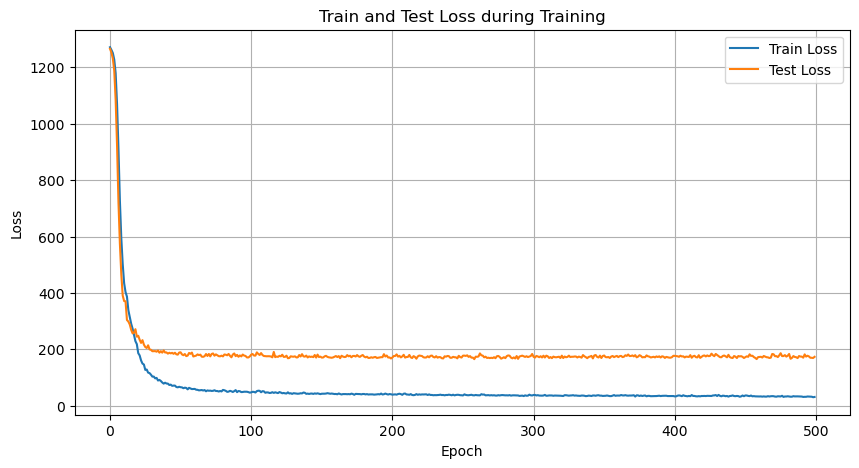

In [160]:
from torch.utils.data import DataLoader, TensorDataset

# Chuyển thành tensor
X_train_tensor = torch.FloatTensor(X_train)
C_train_tensor = torch.FloatTensor(C_train)
X_test_tensor = torch.FloatTensor(X_test)
C_test_tensor = torch.FloatTensor(C_test)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, C_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, C_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Khởi tạo mô hình và optimizer
cvae = CVAE()
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Danh sách lưu loss
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_path = 'best_cvae_model.pth'

# Huấn luyện
num_epochs = 500
for epoch in range(num_epochs):
    # Huấn luyện trên tập train
    cvae.train()
    total_train_loss = 0
    for x, condition in train_loader:
        x_recon, mean, logvar = cvae(x, condition)
        loss = loss_function(x_recon, x, mean, logvar, beta=0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Đánh giá trên tập test
    cvae.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, condition in test_loader:
            x_recon, mean, logvar = cvae(x, condition)
            loss = loss_function(x_recon, x, mean, logvar, beta=0.5)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    # Lưu mô hình tốt nhất dựa trên test loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(cvae.state_dict(), best_model_path)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Đọc lại mô hình tốt nhất
cvae_loaded = CVAE()
cvae_loaded.load_state_dict(torch.load(best_model_path))
cvae_loaded.eval()

# Trực quan hóa loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

Average MSE on Test Set: 0.1249


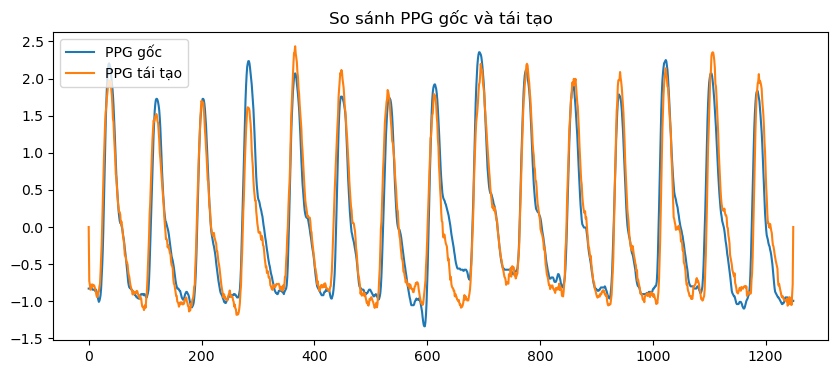

In [161]:
# Đánh giá trên tập test (MSE trung bình)
cvae_loaded.eval()
total_mse = 0
with torch.no_grad():
    for x, condition in test_loader:
        x_recon, _, _ = cvae_loaded(x, condition)
        mse = F.mse_loss(x_recon, x, reduction='mean')
        total_mse += mse.item()
avg_mse = total_mse / len(test_loader)
print(f"Average MSE on Test Set: {avg_mse:.4f}")

# So sánh PPG gốc và tái tạo
plt.figure(figsize=(10, 4))
plt.plot(X_test[0], label='PPG gốc')
plt.plot(x_recon[0].numpy(), label='PPG tái tạo')
plt.legend()
plt.title("So sánh PPG gốc và tái tạo")
plt.show()

# # Tạo PPG với HR tăng dần
# hr_values = [60, 80, 100, 120]
# for hr in hr_values:
#     condition = torch.FloatTensor([[hr, 15]])  # RESP cố định
#     ppg_gen = cvae.decoder(torch.randn(1, 32), condition)
#     plt.plot(ppg_gen[0].detach().numpy(), label=f'HR={hr}')
# plt.legend()
# plt.title("PPG tạo sinh với HR thay đổi")
# plt.show()

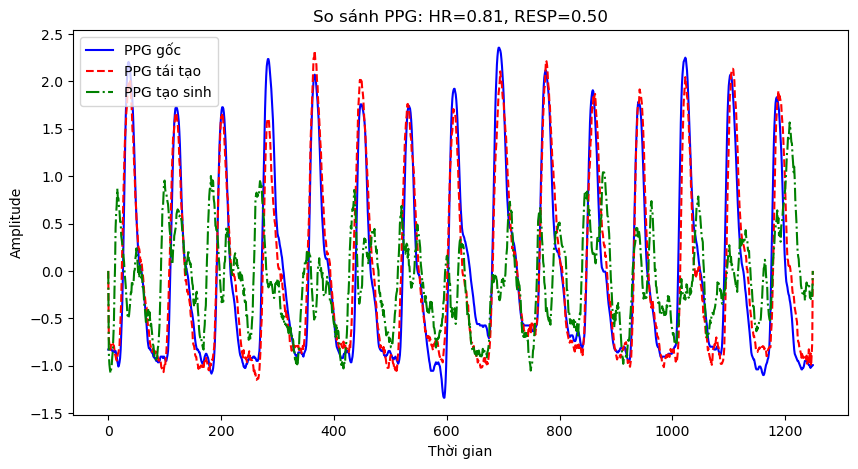

In [162]:
import matplotlib.pyplot as plt
import torch

# Giả sử bạn đã có X_test_tensor (dữ liệu PPG gốc) và C_test_tensor (điều kiện HR/RESP) từ tập test
# Chọn một mẫu từ tập test (ví dụ: mẫu đầu tiên)
index = 0
x_original = X_test_tensor[index]  # PPG gốc
c_original = C_test_tensor[index]  # Điều kiện HR/RESP của mẫu

# Tái tạo PPG bằng mô hình CVAE
cvae_loaded.eval()  # Chuyển sang chế độ đánh giá
with torch.no_grad():
    x_recon, _, _ = cvae_loaded(x_original.unsqueeze(0), c_original.unsqueeze(0))  # Thêm chiều batch

# Tạo PPG tạo sinh với cùng điều kiện HR/RESP
latent_dim = 32  # Giả sử chiều của latent vector là 10, bạn cần điều chỉnh theo mô hình của bạn
z_random = torch.randn(1, latent_dim)  # Tạo latent vector ngẫu nhiên
with torch.no_grad():
    ppg_generated = cvae_loaded.decoder(z_random, c_original.unsqueeze(0))  # Tạo PPG mới

# Vẽ đồ thị so sánh
plt.figure(figsize=(10, 5))
plt.plot(x_original.numpy(), label='PPG gốc', color='blue')  # PPG gốc
plt.plot(x_recon[0].numpy(), label='PPG tái tạo', color='red', linestyle='--')  # PPG tái tạo
plt.plot(ppg_generated[0].numpy(), label='PPG tạo sinh', color='green', linestyle='-.')  # PPG tạo sinh
plt.title(f'So sánh PPG: HR={c_original[0]:.2f}, RESP={c_original[1]:.2f}')
plt.legend()
plt.xlabel('Thời gian')
plt.ylabel('Amplitude')
plt.show()

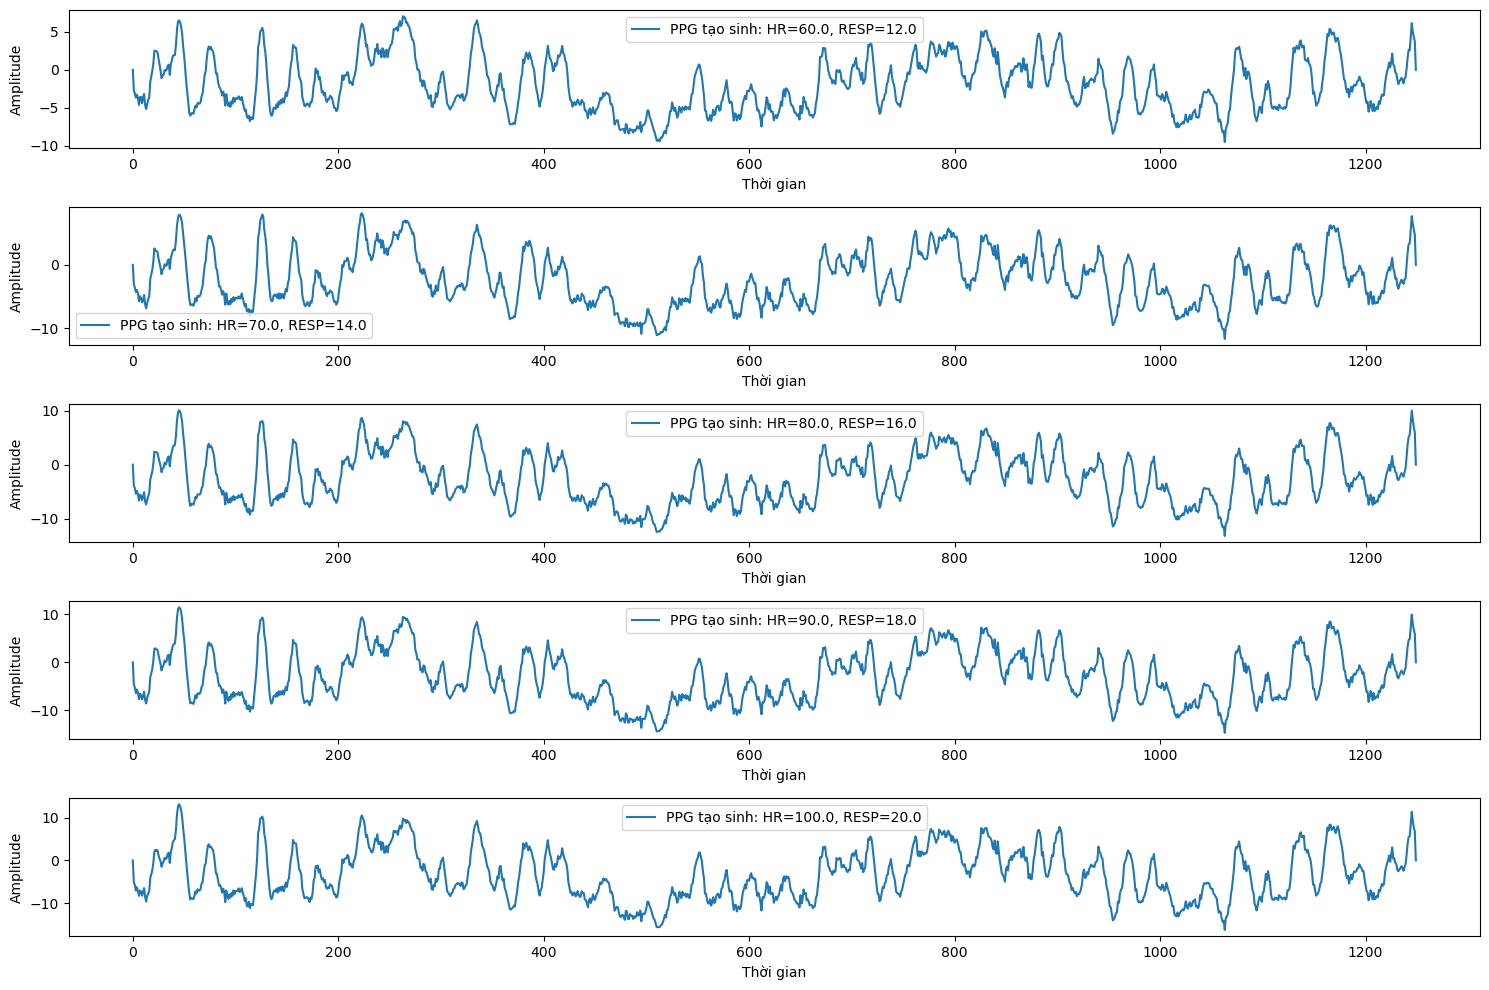

In [163]:
import torch
import matplotlib.pyplot as plt

# Số mẫu PPG muốn tạo
num_generated = 5

# Tạo latent vector ngẫu nhiên
z = torch.randn(num_generated, latent_dim)

# Định nghĩa điều kiện HR và RESP (ví dụ: HR từ 60 đến 100, RESP từ 12 đến 20)
conditions_generated = torch.FloatTensor([
    [60, 12],  # HR=60, RESP=12
    [70, 14],
    [80, 16],
    [90, 18],
    [100, 20]
])

# Tạo PPG mới bằng decoder
cvae_loaded.eval()
with torch.no_grad():
    ppg_generated = cvae_loaded.decoder(z, conditions_generated)

# Vẽ các PPG tạo sinh
plt.figure(figsize=(15, 10))
for i in range(num_generated):
    plt.subplot(num_generated, 1, i+1)
    plt.plot(ppg_generated[i].numpy(), label=f'PPG tạo sinh: HR={conditions_generated[i][0]}, RESP={conditions_generated[i][1]}')
    plt.legend()
    plt.xlabel('Thời gian')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()